## 07. LightGBM
- 부스팅 알고리즘
- XGBoost보다 더 빠른 학습과 예측 수행 시간 + 더 작은 메모리 사용량 + 예측 성능도 거의 차이 X  
  -> XGBoost의 장점 계승, 단점 보완 but 약 1만건 이하의 적은 데이터 세트에 적용할 경우 과적합 발생이 쉬움
- 범주형 피처의 자동 변환과 최적 분할: 원-핫 인코딩 사용 없이도 범주형 피처 최적으로 변환 및 노드 분할 수행
- 리프 중심 트리 분할 방식 사용: 오버피팅에 보다 더 강한 구조를 가질 수 O but 균형을 맞추기 위한 시간이 필요함
  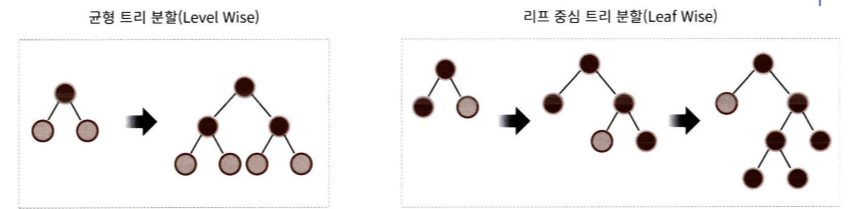   
  -> 트리의 균형을 맞추지 않고, 최대 손실 값 (max delta loss)을 가지는 리프 노드를 지속적으로분할  
  -> 트리 깊이 깊어지고 비대칭적 규칙 트리 생성  
  => 반복할수록 균형트리 방식보다 예측 오류 손실 최소화 가능   
  cf) 일반GBM계열+대부분 트리 기반 알고리즘: 균형트리 분할(Level Wise) 방식 사용-> 균형잡힌 트리 유지하며 분할 -> 깊이 최소화
  
  



#### LightGBM 설치  
: conda install -c conda-forge lightgbm

#### LightGBM 하이퍼 파라미터
-XGBoost와의 차이점: 리프노드가 계속 분할되면서 트리 깊어짐 -> 특성에 맞는 하이퍼 파라미터 설정 필요(max_depth 매우 크게 가짐)  


- 주요 파라미터

    - num_iterations [default = 100] : 반복 수행하려는 트리의 개수 지정(=n_esstimators)
    - learning_rate[default = 0.1]: 0~1사이의 값 지정 -> 부스팅스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값
    - max_depth[default = 1]: 트리 기반 알고리즘의 max_depth와 동일 
    - max_data_in_leaf[default = 20]: 결정 트리의 min_samples_leaf와 같은 파라미터 (lgb_clf->min_child_samples)
    - num_leaves[default = 31]: 하나의 트리가 가질 수 있는 최대 리프 개수
    - boosting[default = gbdt]: 부스팅 트리 생성하는 알고리즘
      * gbdt: 일반적 그래디언트 부스팅 결정 트리 , rf: 랜덤 포레스트
    - bagging_fraction[default=1.0]: 트리가 커져서 과적합 되는 것을 제어하기 위해 데이터를 샘플링하는 비율 지정 (lgb_clf->subsample)
    - feature_fraction[default=1.0]: 개별 트리 학습할 때마다 무작위로 선택하는 피처의 비율 <- 과적합 방지용 (lgb_clf->colsample_bytree)
    - lambda_l2[default=0.0]: L2 regulation 제어 위한 값 -> 피처 개수 많을 수록 적용.. 값이 클수록 과적합 감소 효과 (lgb_clf-reg_lambda)
    - lambda_l1[default=0.0]: L1 regulation 제어 위한 값 -> 과적합 제어 위함 (lgb_clf-reg_alpha)

 
- Learning Task 파라미터  
  : objective - 최솟값을 가져야할 손실 함수 정의, 애플리케이션의 유형(회귀, 다중클래스 분류, 이진분류)에 따라 손실함수 지정

#### 하이퍼 파라미터 튜닝 방안  
: num_leaves 개수 중심으로 min_samples(min_data_in_leaf), max_depth 함께 조정 -> 모델 복잡도 줄여나가는 것 = 기본 튜닝 방안
- num_leaves: LightGBM 모델의 복잡도 제어하는 주요 파라미터 -> 정확도와 비례 but 트리 깊이 깊어지고 모델 복잡도 커짐 -> 과적합 영향 커짐
- min_data_in_leaf(min_child_samples): 과적합 개선에 중요한 파라미터 -> 보통 큰 값으로 설정 -> 트리 깊어지는 것 방지
- max_depth: 깊이 크기 제한, 다른 파라미터와 결합해 과적합 개선에 사용
- 기본 튜닝방안: learning_rate 작게, n_estimators 크게 (단, n_estimators를 크게 하는 것은 과적합으로 인한 성능 저하 유발 가능)

#### 파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 팦라미터 비교 
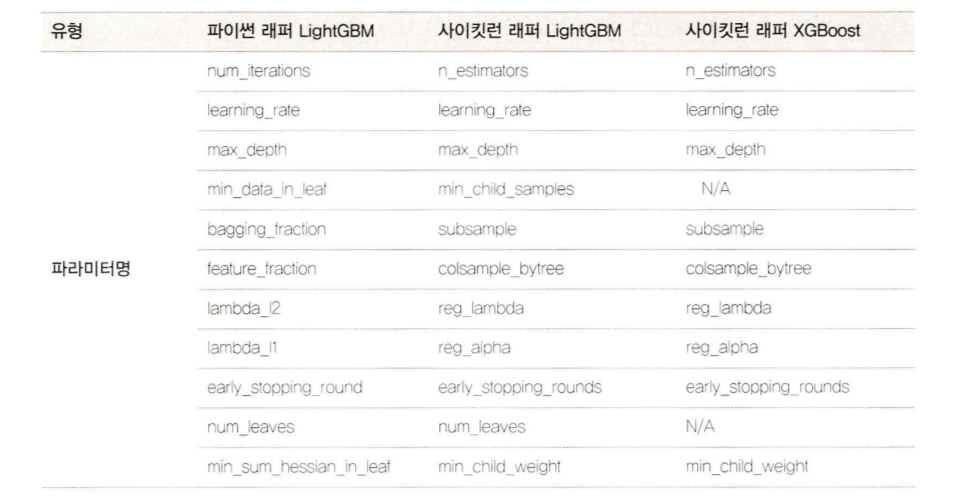

#### LightGBM 적용 - 위스콘신 유방암 예측

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd 
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size = 0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400설정.
lgbm_wrapper=LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set = evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]


C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
def get_clf_eval(y_test, pred=None, pred_proba=None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # roc_auc 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [4]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도 : 0.9561, 정밀도 : 0.9500, 재현율 : 0.9870,     F1 : 0.9682, AUC:0.9905


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

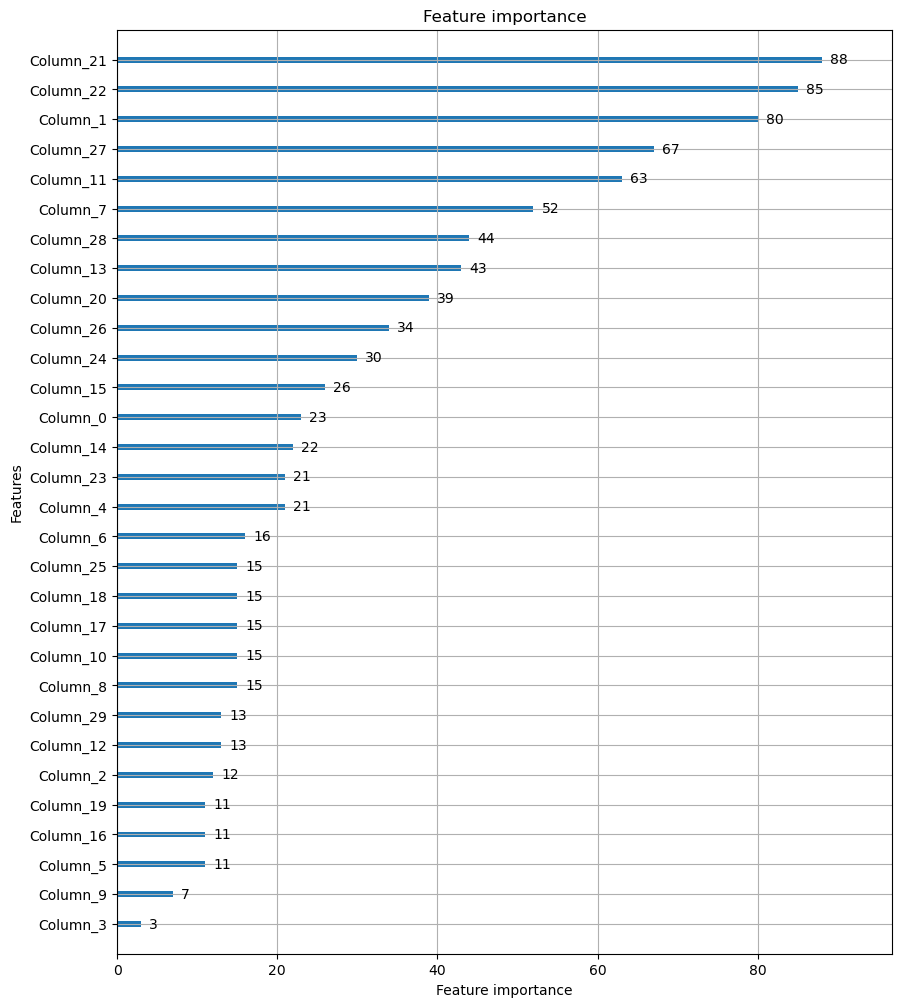

In [5]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

## 08. 분류 실습 - 캐글 산탄데르 고객 만족 예측
- 데이터 세트: 산탄데르 고객만족 데이터 세트
- XGBoost, LightGBM
- 클래스 레이블 명 : TARGET ( 1: 불만 0: 만족 )
- ROC-AUC(ROC 곡선 영역)

#### 데이터 전처리

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('./data/train_santander.csv', encoding = 'latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


전체 데이터에서 만족과 불만족 비율 살펴보기

In [4]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [5]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [6]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
print('피처 데이터 shape: {0}'.format(X_features.shape))

피처 데이터 shape: (76020, 369)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size = 0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape: {0}, 테스트 세트 Shape: {1}'.format(X_train.shape, X_test.shape))

print('학습 세틑 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape: (60816, 369), 테스트 세트 Shape: (15204, 369)
학습 세틑 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


=> 학습과 테스트 데이터 세트 모두 TARGET 값의 분포가 원본 데이터와 유사하게 전체 데이터의 4% 정도의 불만족 값 

#### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

- XGBoost의 학습모델 : 사이킷런 래퍼 XGBClassifier 기반으로 학습 수행

In [42]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82745
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85831	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84055
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.88071	validation_1-auc:0.84117
[16]	validation_0-auc:0.88237	validation_1-auc:0.84101
[17]	validation_0-auc:0.88352	validation_1-auc:0.84071
[18]	validation_0-au

- XGBoost의 하이퍼 파라미터 튜닝

In [45]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트이 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params={ 'max_depth':[5,7], 'min_child_weight':[1,3],'colsample_bytree':[0.5,0.75] }
# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
           eval_set=[(X_train,y_train),(X_test,y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.79161	validation_1-auc:0.79321
[1]	validation_0-auc:0.81865	validation_1-auc:0.81375
[2]	validation_0-auc:0.82586	validation_1-auc:0.81846
[3]	validation_0-auc:0.82789	validation_1-auc:0.82226
[4]	validation_0-auc:0.83249	validation_1-auc:0.82677
[5]	validation_0-auc:0.83477	validation_1-auc:0.83225
[6]	validation_0-auc:0.83340	validation_1-auc:0.82654
[7]	validation_0-auc:0.84223	validation_1-auc:0.83487
[8]	validation_0-auc:0.84586	validation_1-auc:0.83682
[9]	validation_0-auc:0.84557	validation_1-auc:0.83472
[10]	validation_0-auc:0.84423	validation_1-auc:0.83181
[11]	validation_0-auc:0.84428	validation_1-auc:0.82920
[12]	validation_0-auc:0.85176	validation_1-auc:0.83433
[13]	validation_0-auc:0.85540	validation_1-auc:0.83565
[14]	validation_0-auc:0.85719	validation_1-auc:0.83696
[15]	validation_0-auc:0.85849	validation_1-auc:0.83561
[16]	validation_0-auc:0.85964	validation_1-auc:0.83578
[17]	validation_0-auc:0.86092	validation_1-auc:0.83570
[18]	validation_0-au

- 최적화 하이퍼 파라미터 기반하여 다시 최적화 진행  
  : 책과 출력된 최적 파라미터가 달라 결과로 나온 최적 파라미터로 코드 작성함.

In [48]:
# n_estimators는 1000으로 증가시키고, lerning_rate=0.2로 감소, reg_alpha=0.03으로 추가함.
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.2, max_depth=5,
                        min_child_weight=3, colsample_bytree=0.5, reg_alpha=0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200,
            eval_metric='auc', eval_set = [(X_train, y_train),(X_test,y_test)])

xgb_roc_score=roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.72742	validation_1-auc:0.73391
[1]	validation_0-auc:0.81588	validation_1-auc:0.81936
[2]	validation_0-auc:0.81196	validation_1-auc:0.81287
[3]	validation_0-auc:0.81672	validation_1-auc:0.81280
[4]	validation_0-auc:0.81426	validation_1-auc:0.81234
[5]	validation_0-auc:0.82687	validation_1-auc:0.82368
[6]	validation_0-auc:0.83521	validation_1-auc:0.83142
[7]	validation_0-auc:0.84110	validation_1-auc:0.83397
[8]	validation_0-auc:0.84514	validation_1-auc:0.83681
[9]	validation_0-auc:0.84269	validation_1-auc:0.83396
[10]	validation_0-auc:0.84605	validation_1-auc:0.83829
[11]	validation_0-auc:0.84593	validation_1-auc:0.83753
[12]	validation_0-auc:0.84996	validation_1-auc:0.83886
[13]	validation_0-auc:0.84796	validation_1-auc:0.83830
[14]	validation_0-auc:0.85188	validation_1-auc:0.84061
[15]	validation_0-auc:0.85121	validation_1-auc:0.83860
[16]	validation_0-auc:0.85477	validation_1-auc:0.84061
[17]	validation_0-auc:0.85416	validation_1-auc:0.84018
[18]	validation_0-au

In [ ]:
'''
# 교재에서 출력된 최적 파라미터 기준

# n_estimators는 1000으로 증가시키고, lerning_rate=0.2로 감소, reg_alpha=0.03으로 추가함.
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.2, max_depth=7,
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200,
            eval_metric='auc', eval_set = [(X_train, y_train),(X_test,y_test)])

xgb_roc_score=roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))
'''

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

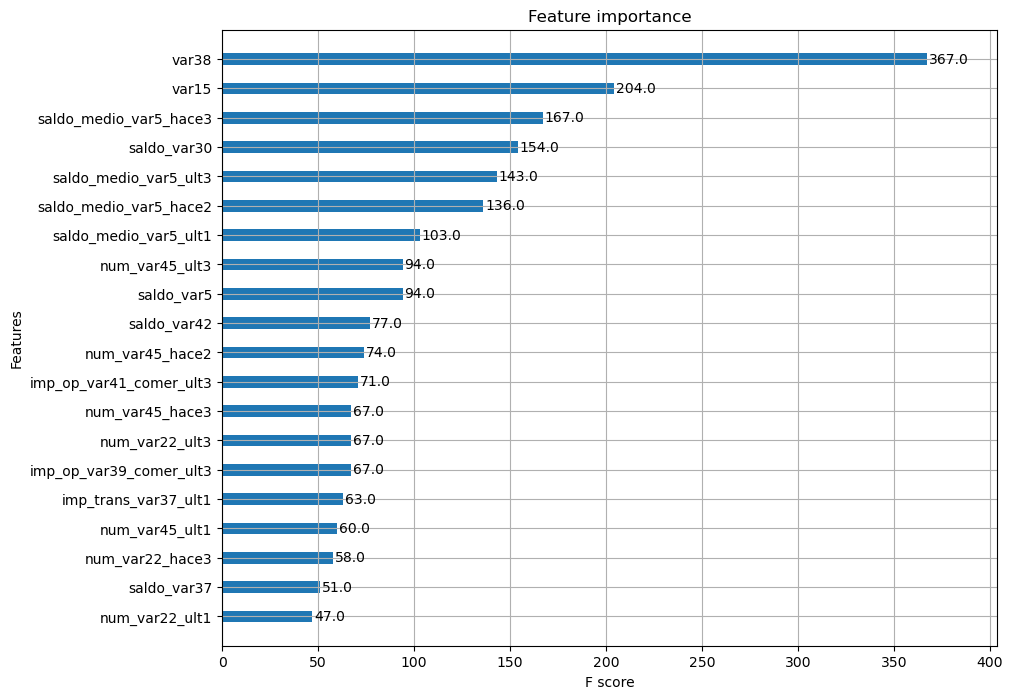

In [50]:
# 튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타내기 : xgboost모듈의 plot_importance()메서드
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize = (10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

#### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [9]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

lgbm_clf=LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, 
             verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC_AUC: {0:.4f}'.format(lgbm_roc_score))

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_logloss: 0.14161
[16]	valid_0's auc: 0.840337	valid_0's binary_loglo

In [12]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
lgbm_clf=LGBMClassifier(n_estimators=100)

params = {'num_leaves':[32,64],
          'max_depth':[128,160],
          'min_child_samples':[60,100],
         'subsample':[0.8,1]}

# cv는 3으로 지정
gridcv=GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
           eval_set=[(X_train, y_train),(X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	valid_1's binary_logloss: 0.146417
[9]	valid_0's auc: 0.851646

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	valid_1's binary_logloss: 0.146491
[9]	valid_0's auc: 0.849282	

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	valid_1's binary_logloss: 0.146634
[9]	valid_0's auc: 0.863391	va

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss: 0.137458	valid_1's auc: 0.834885	valid_1's binary_logloss: 0.148761
[7]	valid_0's auc: 0.863011	valid_0's binary_logloss: 0.135522	valid_1's auc: 0.835812	valid_1's binary_logloss: 0.147245
[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.86570

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
[2]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.149977	valid_1's auc: 0.822571	valid_1's binary_logloss: 0.159808
[3]	valid_0's auc: 0.847366	valid_0's binary_logloss: 0.145866	valid_1's auc: 0.829312	valid_1's binary_logloss: 0.156171
[4]	valid_0's auc: 0.850911	valid_0's binary_logloss: 0.14247	valid_1's auc: 0.830848	valid_1's binary_logloss: 0.153328
[5]	valid_0's auc: 0.854674	valid_0's binary_logloss: 0.139764	valid_1's auc: 0.833041	valid_1's binary_logloss: 0.151023
[6]	valid_0's auc: 0.856722	valid_0's binary_logloss: 0.1375	valid_1's auc: 0.834264	valid_1's binary_logloss: 0.149166
[7]	valid_0's auc: 0.858253	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.147631
[8]	valid_0's auc: 0.859768	valid_0's binary_logloss: 0.134063	valid_1's auc: 0.835678	valid_1's binary_logloss: 0.146384
[9]	valid_0's auc: 0.86262	

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	valid_1's binary_logloss: 0.146757
[9]	valid_0's auc: 0.84844

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss: 0.142024	valid_1's auc: 0.836918	valid_1's binary_logloss: 0.150735
[6]	valid_0's auc: 0.848041	valid_0's binary_logloss: 0.140009	valid_1's auc: 0.838831	valid_1's binary_logloss: 0.148771
[7]	valid_0's auc: 0.849655	valid_0's binary_logloss: 0.138307	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.147373
[8]	valid_0's auc: 0.85185	valid_0's binary_logloss: 0.136891	valid_1's auc: 0.838955	valid_1's binary_logloss: 0.146094
[9]	valid_0's auc: 0.853067	va

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.821427	valid_0's binary_logloss: 0.156592	valid_1's auc: 0.81711	valid_1's binary_logloss: 0.165273
[2]	valid_0's auc: 0.827893	valid_0's binary_logloss: 0.151336	valid_1's auc: 0.820533	valid_1's binary_logloss: 0.160243
[3]	valid_0's auc: 0.83753	valid_0's binary_logloss: 0.147487	valid_1's auc: 0.82841	valid_1's binary_logloss: 0.156547
[4]	valid_0's auc: 0.84038	valid_0's binary_logloss: 0.144428	valid_1's auc: 0.8313	valid_1's binary_logloss: 0.153575
[5]	valid_0's auc: 0.842945	valid_0's binary_logloss: 0.142089	valid_1's auc: 0.833579	valid_1's binary_logloss: 0.151354
[6]	valid_0's auc: 0.843246	valid_0's binary_logloss: 0.140186	valid_1's auc: 0.833781	valid_1's binary_logloss: 0.14953
[7]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.138471	valid_1's auc: 0.834317	valid_1's binary_logloss: 0.147954
[8]	valid_0's auc: 0.846945	valid_0's binary_logloss: 0.137078	valid_1's auc: 0.834895	valid_1's binary_logloss: 0.146786
[9]	valid_0's auc: 0.849381	val

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	valid_1's binary_logloss: 0.146607
[9]	valid_0's auc: 0.86143	v

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
[2]	valid_0's auc: 0.842931	valid_0's binary_logloss: 0.1503	valid_1's auc: 0.82699	valid_1's binary_logloss: 0.15948
[3]	valid_0's auc: 0.850877	valid_0's binary_logloss: 0.14631	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.155775
[4]	valid_0's auc: 0.854431	valid_0's binary_logloss: 0.143104	valid_1's auc: 0.83392	valid_1's binary_logloss: 0.152698
[5]	valid_0's auc: 0.85663	valid_0's binary_logloss: 0.140582	valid_1's auc: 0.835094	valid_1's binary_logloss: 0.150349
[6]	valid_0's auc: 0.859142	valid_0's binary_logloss: 0.138289	valid_1's auc: 0.836166	valid_1's binary_logloss: 0.148424
[7]	valid_0's auc: 0.861364	valid_0's binary_logloss: 0.136413	valid_1's auc: 0.837184	valid_1's binary_logloss: 0.146912
[8]	valid_0's auc: 0.862199	valid_0's binary_logloss: 0.134841	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.145726
[9]	valid_0's auc: 0.864095	val

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.834724	valid_0's binary_logloss: 0.15607	valid_1's auc: 0.822983	valid_1's binary_logloss: 0.165104
[2]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.150494	valid_1's auc: 0.830472	valid_1's binary_logloss: 0.159671
[3]	valid_0's auc: 0.847187	valid_0's binary_logloss: 0.146306	valid_1's auc: 0.830873	valid_1's binary_logloss: 0.155985
[4]	valid_0's auc: 0.850394	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830975	valid_1's binary_logloss: 0.15321
[5]	valid_0's auc: 0.853379	valid_0's binary_logloss: 0.140508	valid_1's auc: 0.832135	valid_1's binary_logloss: 0.150854
[6]	valid_0's auc: 0.855463	valid_0's binary_logloss: 0.138297	valid_1's auc: 0.833116	valid_1's binary_logloss: 0.149013
[7]	valid_0's auc: 0.856723	valid_0's binary_logloss: 0.136504	valid_1's auc: 0.833811	valid_1's binary_logloss: 0.147577
[8]	valid_0's auc: 0.858076	valid_0's binary_logloss: 0.13495	valid_1's auc: 0.835315	valid_1's binary_logloss: 0.146273
[9]	valid_0's auc: 0.861024

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's auc: 0.824305	training's binary_logloss: 0.156217	valid_1's auc: 0.819488	valid_1's binary_logloss: 0.165016
[2]	training's auc: 0.828798	training's binary_logloss: 0.150959	valid_1's auc: 0.822075	valid_1's binary_logloss: 0.159734
[3]	training's auc: 0.839609	training's binary_logloss: 0.147147	valid_1's auc: 0.829436	valid_1's binary_logloss: 0.156119
[4]	training's auc: 0.845158	training's binary_logloss: 0.144107	valid_1's auc: 0.836147	valid_1's binary_logloss: 0.153073
[5]	training's auc: 0.847711	training's binary_logloss: 0.14162	valid_1's auc: 0.839041	valid_1's binary_logloss: 0.150773
[6]	training's auc: 0.849184	training's binary_logloss: 0.139622	valid_1's auc: 0.839076	valid_1's binary_logloss: 0.148948
[7]	training's auc: 0.85094	training's binary_logloss: 0.13786	valid_1's auc: 0.839943	valid_1's binary_logloss: 0.147346
[8]	training's auc: 0.853386	training's binary_logloss: 0.136418	valid_1's auc: 0.84098	valid_1's binary_logloss: 0.146068
[9]	training

In [14]:
# 최적 파라미터를 적용하여 다시 학습
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=100, max_depth=128)

evals=[(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals,
             verbose=True)

lgbm_roc_score=roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\leehj\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.141254
[16]	valid_0's auc: 0.841108	valid_0's binary_logloss: 0